In [1]:
import geopandas as gpd
from tqdm import tqdm
from shapely.validation import explain_validity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import calendar
from itertools import cycle

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
file = "../data/shapefiles/FAPAN_level_07/FAPAN_level_07_inclusive.shp"    

# open file
shp = gpd.read_file(file)
df = pd.read_csv("../data/FAPAN_level_07.csv")

In [3]:
df = df.drop("SUBIDs", axis=1)
df = df.rename(columns={"HYBAS_ID" : "SUBID"})
shp = shp.rename(columns={"HYBAS_ID" : "SUBID"})
df

,SUBID,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,2070000010,-1.479092,-1.461161,-1.453289,-1.481299,-1.449651,-1.545862,-1.579616,-1.687005,-1.750921,...,1.655333,1.592781,0.853791,1.173939,1.140341,1.228164,1.138968,0.679221,1.044652,1.435165
1,2070000020,-1.322753,-0.781449,-1.047273,-1.703376,-1.276926,-1.180634,-1.538944,-1.531854,-1.246925,...,0.404243,0.260235,0.599397,1.216978,0.375715,-0.147517,-0.201637,-0.408996,0.149820,0.526136
2,2070000030,-1.525035,-1.113620,-1.350137,-1.613114,-1.410301,-1.400624,-1.571780,-1.620268,-1.442330,...,1.460454,1.235448,0.879883,1.515541,1.158499,0.869266,0.876306,0.564344,1.104095,1.402583
3,2070000240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2070816790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4057,2070099470,-1.222142,-0.711898,-0.088376,-1.146354,-0.838684,-0.836202,-0.209959,0.100777,0.268928,...,1.198548,2.198667,2.341377,1.601097,1.100800,1.080092,1.160548,0.472319,0.367013,-0.033820
4058,2070099690,0.119064,-0.136186,0.075601,-0.777327,-0.387475,0.855242,0.448400,-0.593276,-0.178350,...,-1.487927,-0.121175,0.295587,-2.047816,-1.136042,0.584246,1.187967,1.036153,0.237141,0.450584
4059,2070101800,-0.510093,-0.410916,0.020650,-0.066599,-0.429246,0.713828,0.363515,0.253769,0.206735,...,0.440076,0.602225,0.888801,-1.999916,-0.426395,-0.770768,-0.404979,-0.365298,-0.123865,-1.388836
4060,2070104700,0.568573,0.396927,-0.961753,-0.707343,-0.173271,0.445322,0.454190,-0.393404,0.600451,...,-1.008761,-0.679805,-0.816639,-1.451800,0.705150,0.560013,-0.352160,-1.562156,-0.273103,0.484693


In [4]:
# Calculate centroids
shp['centroid'] = shp['geometry'].centroid

# Extract latitude and longitude
shp['LATITUDE'] = shp['centroid'].apply(lambda centroid: centroid.y)
shp['LONGITUDE'] = shp['centroid'].apply(lambda centroid: centroid.x)

# Drop the 'centroid' column if needed
shp = shp.drop('centroid', axis=1)

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_38045/1722491891.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['centroid'] = shp['geometry'].centroid


In [5]:
df.insert(1, 'x', shp['LONGITUDE'])
#df['x'] = df['x'].astype(float)
df.insert(2, 'y', shp['LATITUDE'])
#df['y'] = df['y'].astype(float)

In [6]:
def select_columns_by_months(dataframe, selected_months):
    selected_columns = []

    for i in range((dataframe.shape[1] - 3) // 12):
        selected_columns.extend([month + i * 12 for month in selected_months])

    all_columns = np.arange(1, dataframe.shape[1] - 2)
    columns_to_drop = np.setdiff1d(all_columns, np.array(selected_columns))
    columns_to_drop = [str(i) for i in columns_to_drop]

    filtered_dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

    return filtered_dataframe

100%|██████████| 12/12 [00:49<00:00,  4.11s/it]

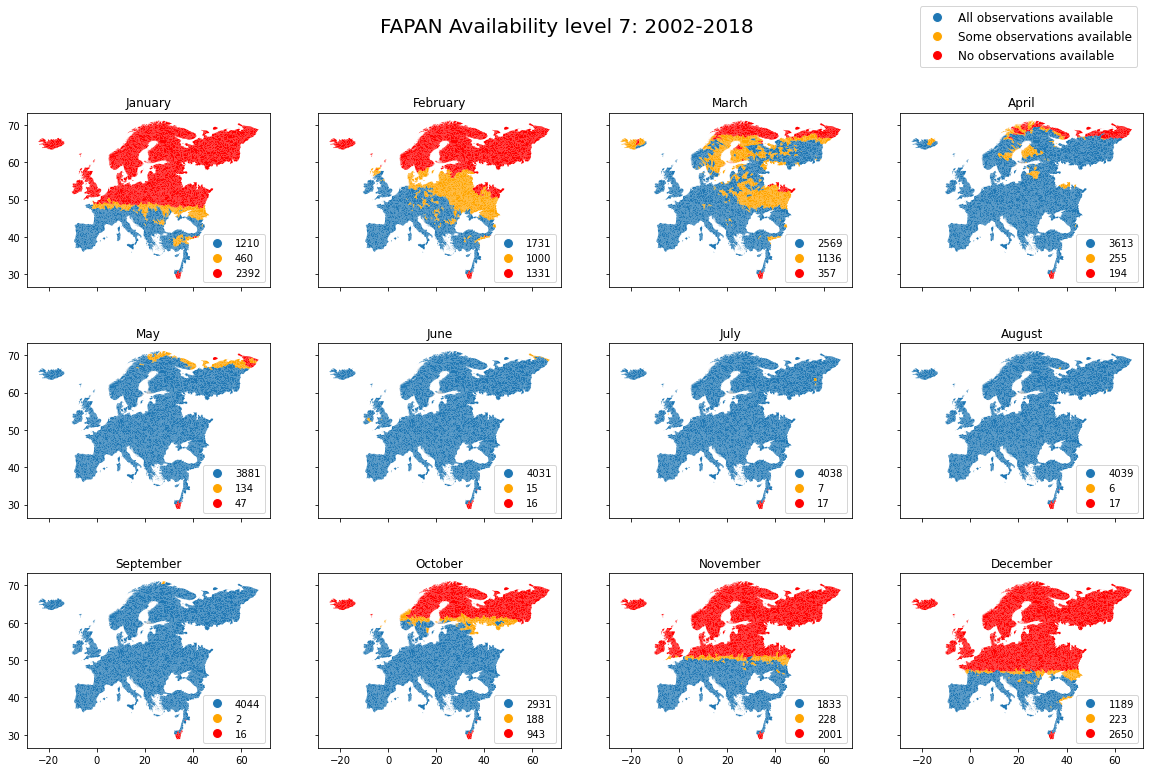

In [70]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True,)
fig.suptitle('FAPAN Availability level 7: 2002-2018', fontsize=20)
colors = {'df_month_no_na': 'C0', 'df_month_some_na': 'orange', 'df_month_all_na': 'red'}

progress_bar = tqdm(total=12, position=0, leave=True, smoothing=0)

k = 1
for i in range(3):
    for j in range(4):
        df_month = select_columns_by_months(df, [k])
        selected_columns = df_month.iloc[:, 3:]

        df_month_no_na = df_month.dropna()
        df_month_some_na = df_month[selected_columns.isnull().any(axis=1) & ~selected_columns.isnull().all(axis=1)]
        df_month_all_na = df_month[selected_columns.isnull().all(axis=1)]

        shp.plot(ax=axs[i][j], color=[colors.get('df_month_no_na') if subid in df_month_no_na['SUBID'].values
                                       else colors.get('df_month_some_na') if subid in df_month_some_na['SUBID'].values
                                       else colors.get('df_month_all_na') for subid in shp['SUBID']])

        month_name = calendar.month_name[k]
        axs[i][j].set_title(f'{month_name}', fontsize=12)

        # Count the occurrences of each color
        color_counts = [str(len(df_month_no_na)), str(len(df_month_some_na)), str(len(df_month_all_na))]

        axs[i][j].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
                                  for color in colors.values()],
                         labels=color_counts,
                         loc='lower right', fontsize=10)

        k += 1
        progress_bar.update(1)

# Create a legend outside the loop for the last plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
labels = ['All observations available', 'Some observations available', 'No observations available']
fig.legend(handles=handles, labels=labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.9, 1))

#plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9, wspace=0.3, hspace=0.3)

#plt.savefig(fname='availability_each_month.png')

plt.show()